In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("seaninggg/crisismmd-multimodal-crisis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/crisismmd-multimodal-crisis-dataset


In [ ]:

!pip install kagglehub transformers==4.40.2 pillow tqdm scikit-learn

In [14]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

dataset_root = "/kaggle/input/crisismmd-multimodal-crisis-dataset/CrisisMMD_v2.0"

data_dir = os.path.join(dataset_root, "crisismmd_datasplit_all", "crisismmd_datasplit_all")
train_file = os.path.join(data_dir, "task_informative_text_img_train.tsv")
dev_file   = os.path.join(data_dir, "task_informative_text_img_dev.tsv")
test_file  = os.path.join(data_dir, "task_informative_text_img_test.tsv")

img_root = os.path.join(dataset_root, "data_image")


2025-06-16 17:12:17.785563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750093937.997297      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750093938.060974      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
import pandas as pd

train_df = pd.read_csv(train_file, sep='\t')
dev_df = pd.read_csv(dev_file, sep='\t')
test_df = pd.read_csv(test_file, sep='\t')

label_encoder = LabelEncoder()


def auto_map(text):
    t = text.lower()
    if 'urgent' in t or 'help' in t:
        return 'Urgent Help'
    elif 'relief' in t or 'rescue' in t:
        return 'Relief Info'
    elif 'fake' in t or 'misinfo' in t or 'rumor' in t:
        return 'Misinformation'
    else:
        return 'Irrelevant'

for df in [train_df, dev_df, test_df]:
    df['label'] = df['tweet_text'].apply(auto_map)  # 或直接用已有字段

print(train_df['label'].value_counts())


label
Irrelevant        11665
Urgent Help        1038
Relief Info         870
Misinformation       35
Name: count, dtype: int64


In [17]:
from sklearn.preprocessing import LabelEncoder

all_labels = pd.concat([train_df['label'], dev_df['label'], test_df['label']])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
num_classes = len(label_encoder.classes_)
print(label_encoder.classes_)


['Irrelevant' 'Misinformation' 'Relief Info' 'Urgent Help']


In [18]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CrisisMMDataset(Dataset):
    def __init__(self, df, dataset_root, tokenizer, max_length=128, label_encoder=None):
        self.df = df.reset_index(drop=True)
        self.dataset_root = dataset_root
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['tweet_text'])
        img_path = os.path.join(self.dataset_root, row['image'])
        image = Image.open(img_path).convert("RGB")
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        label = self.label_encoder.transform([row['label']])[0]
        return {
            "input_ids": encoding['input_ids'].squeeze(0),
            "attention_mask": encoding['attention_mask'].squeeze(0),
            "image": image,
            "label": torch.tensor(label, dtype=torch.long)
        }


In [ ]:
!pip install sentencepiece


In [19]:
from transformers import BlipProcessor, BlipForConditionalGeneration, XLMRobertaTokenizer, XLMRobertaModel

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlm_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [22]:

dataset_root = '/kaggle/input/crisismmd-multimodal-crisis-dataset/CrisisMMD_v2.0'  # 换成你的图片根目录

train_dataset = CrisisMMDataset(train_df, dataset_root, xlm_tokenizer, label_encoder=label_encoder)
val_dataset   = CrisisMMDataset(dev_df, dataset_root, xlm_tokenizer, label_encoder=label_encoder)
test_dataset  = CrisisMMDataset(test_df, dataset_root, xlm_tokenizer, label_encoder=label_encoder)

def collate_fn(batch):
    images = [x['image'] for x in batch]
    pixel_values = blip_processor(images=images, return_tensors="pt")['pixel_values']
    input_ids = torch.stack([x['input_ids'] for x in batch])
    attention_mask = torch.stack([x['attention_mask'] for x in batch])
    labels = torch.stack([x['label'] for x in batch])
    return {"image": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask, "label": labels}

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)


In [23]:
import torch.nn as nn

class CrisisClassifier(nn.Module):
    def __init__(self, blip_model, xlm_model, hidden_dim=512, n_classes=4):
        super().__init__()
        self.blip_model = blip_model
        self.xlm_model = xlm_model
        self.fc = nn.Sequential(
            nn.Linear(blip_model.config.vision_config.hidden_size + xlm_model.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        vision_emb = self.blip_model.vision_model(images).last_hidden_state[:,0]
        text_emb = self.xlm_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:,0]
        concat = torch.cat([vision_emb, text_emb], dim=1)
        out = self.fc(concat)
        return out


In [86]:
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrisisClassifier(blip_model, xlm_model, n_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    y_true, y_pred = [], []
    pbar = tqdm(loader, desc='[Train]', ncols=80)
    for batch in pbar:
        optimizer.zero_grad()
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        y_true += labels.cpu().tolist()
        y_pred += outputs.argmax(1).cpu().tolist()
        # 实时显示batch级loss
        pbar.set_postfix(loss=loss.item())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return total_loss / len(loader), acc, f1

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    all_probs = []
    pbar = tqdm(loader, desc='[Eval]', ncols=80)
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images, input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            y_true += labels.cpu().tolist()
            y_pred += outputs.argmax(1).cpu().tolist()
            all_probs.append(probs.cpu().numpy())
            pbar.set_postfix(loss=loss.item())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    all_probs = np.concatenate(all_probs, axis=0)
    return total_loss / len(loader), acc, f1, cm, y_true, y_pred, all_probs


num_epochs = 3
best_f1 = 0
patience = 3
no_improve = 0

for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_cm, _, _, _ = eval_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.3f}, F1: {train_f1:.3f} | Val Acc: {val_acc:.3f}, F1: {val_f1:.3f}")
    print(f"Val Confusion Matrix:\n{val_cm}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load('best_model.pth'))


[Train]:  32%|█████           | 1086/3402 [13:44<29:30,  1.31it/s, loss=0.00535]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[Eval]: 100%|█████████████████████| 560/560 [02:34<00:00,  3.63it/s, loss=0.114]


Epoch 1: Train Acc: 0.932, F1: 0.588 | Val Acc: 0.869, F1: 0.232
Val Confusion Matrix:
[[1944    0    0    0]
 [   5    0    0    0]
 [ 122    0    0    0]
 [ 166    0    0    0]]


[Train]:  13%|██▍                | 440/3402 [05:32<37:09,  1.33it/s, loss=0.715]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[Eval]: 100%|█████████████████████| 560/560 [02:34<00:00,  3.62it/s, loss=0.157]


Epoch 2: Train Acc: 0.857, F1: 0.231 | Val Acc: 0.869, F1: 0.232
Val Confusion Matrix:
[[1944    0    0    0]
 [   5    0    0    0]
 [ 122    0    0    0]
 [ 166    0    0    0]]


[Train]:  75%|█████████████▌    | 2559/3402 [32:14<10:28,  1.34it/s, loss=0.269]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[Eval]: 100%|█████████████████████| 560/560 [02:35<00:00,  3.61it/s, loss=0.169]


Epoch 3: Train Acc: 0.857, F1: 0.231 | Val Acc: 0.869, F1: 0.232
Val Confusion Matrix:
[[1944    0    0    0]
 [   5    0    0    0]
 [ 122    0    0    0]
 [ 166    0    0    0]]


<All keys matched successfully>

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


In [88]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc(y_true, y_score, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        if isinstance(y_score, list):
            y_score = np.array(y_score)
        if y_score.ndim == 1:
            pos_score = y_score
        elif y_score.shape[1] == 1:
            pos_score = y_score[:, 0]
        else:
            pos_score = y_score[:, 1]
        fpr, tpr, _ = roc_curve(y_true, pos_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [89]:
from sklearn.metrics import classification_report

def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    scores = [report[name]['f1-score'] for name in class_names]
    plt.figure(figsize=(6, 4))
    plt.bar(class_names, scores)
    plt.ylabel('F1-score')
    plt.title('F1-score per class')
    plt.ylim(0,1)
    plt.show()


In [93]:
def show_misclassified_samples(texts, images, y_true, y_pred, class_names, num_show=5):
    from PIL import Image
    import matplotlib.pyplot as plt
    mis_idx = [i for i, (a, b) in enumerate(zip(y_true, y_pred)) if a != b]
    print(f"Showing {min(num_show, len(mis_idx))} misclassified samples:")
    for idx in mis_idx[:num_show]:
        print(f"\nSample #{idx}")
        print(f"Text: {texts[idx]}")
        print(f"True Label: {class_names[y_true[idx]]}")
        print(f"Predicted: {class_names[y_pred[idx]]}")
        try:
            img = Image.open(images[idx])
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"[Warning] Cannot open image {images[idx]}: {e}")


In [94]:
def analyze_model(model, test_loader, criterion, device, class_names, 
                  test_texts=None, test_images=None, num_error=5):
    test_loss, test_acc, test_f1, test_cm, y_true, y_pred, y_score = eval_epoch(
        model, test_loader, criterion, device)
    print(f"\n==== Test Results ====")
    print(f"Test Loss: {test_loss:.3f}")
    print(f"Test Acc: {test_acc:.3f}")
    print(f"Test F1 : {test_f1:.3f}")
    print(f"Test Confusion Matrix:\n{test_cm}")

    plot_confusion_matrix(test_cm, class_names)
    plot_multiclass_roc(y_true, y_score, class_names)
    plot_classification_report(y_true, y_pred, class_names)
    if test_texts is not None and test_images is not None:
        show_misclassified_samples(test_texts, test_images, y_true, y_pred, class_names, num_show=num_error)


[Eval]:   1%|▏                      | 5/560 [00:01<02:39,  3.48it/s, loss=0.854]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[Eval]: 100%|█████████████████████| 560/560 [02:34<00:00,  3.63it/s, loss=0.113]



==== Test Results ====
Test Loss: 0.515
Test Acc: 0.864
Test F1 : 0.232
Test Confusion Matrix:
[[1932    0    0    0]
 [   8    0    0    0]
 [ 130    0    0    0]
 [ 167    0    0    0]]


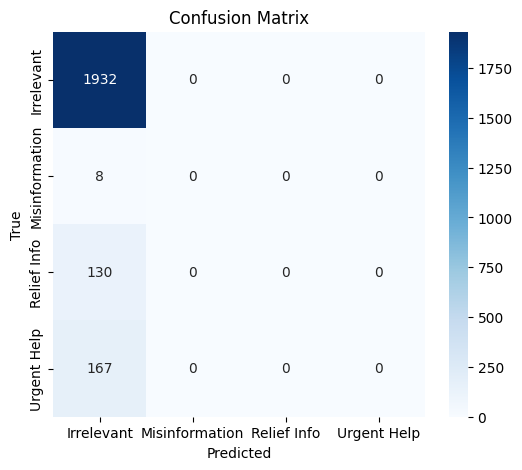

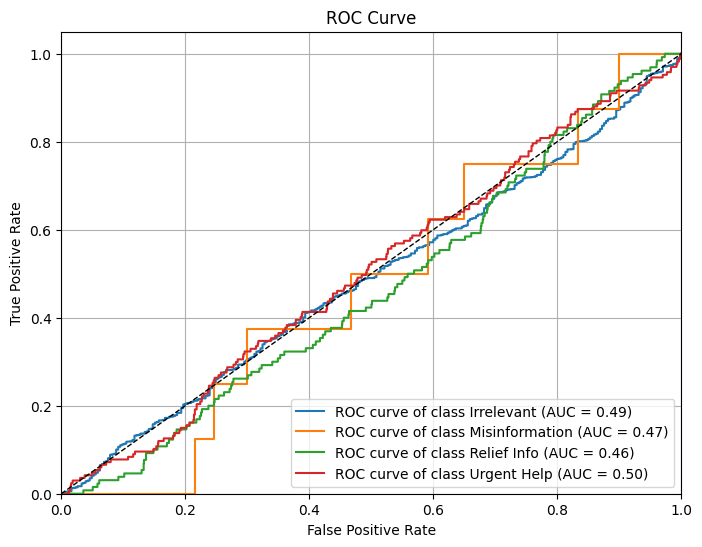

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


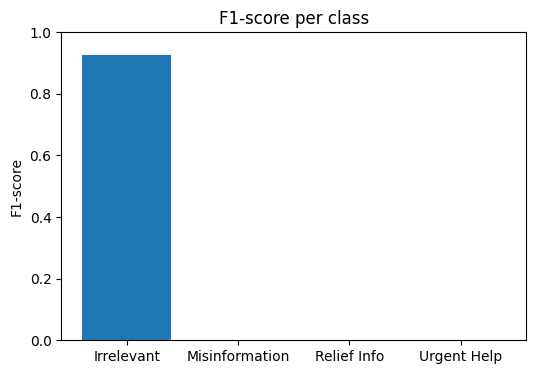

Showing 5 misclassified samples:

Sample #1
Text: RT @THS_College: On our way to Warrior Restoration to help organize donations for #hurricaneharvey! https://t.co/vMheEvAyew
True Label: Urgent Help
Predicted: Irrelevant
[Warning] Cannot open image data_image/hurricane_harvey/8_9_2017/906258753707790336_0.jpg: [Errno 2] No such file or directory: 'data_image/hurricane_harvey/8_9_2017/906258753707790336_0.jpg'

Sample #3
Text: ZZ Top Donating ‘La Grange’ Download Sales To Hurricane Harvey Relief https://t.co/1toIN7bYEo via #IndieBrew https://t.co/R7DmfmG35F
True Label: Relief Info
Predicted: Irrelevant
[Warning] Cannot open image data_image/hurricane_harvey/8_9_2017/906219963152785408_0.jpg: [Errno 2] No such file or directory: 'data_image/hurricane_harvey/8_9_2017/906219963152785408_0.jpg'

Sample #17
Text: Norfolk News Dominion Energy crews helping restore power in Florida after Irma https://t.co/Jbpm76lmgN https://t.co/n7L70Orrnt
True Label: Urgent Help
Predicted: Irrelevant
[Warning]

In [95]:
model.load_state_dict(torch.load('best_model.pth'))
analyze_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    class_names=label_encoder.classes_.tolist(),
    test_texts=test_df['tweet_text'].tolist(),   # 可选
    test_images=test_df['image'].tolist(),       # 可选
    num_error=5
)



In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

vectorizer = TfidfVectorizer(max_features=1024)
X_train = vectorizer.fit_transform(train_df['tweet_text'])
X_val = vectorizer.transform(dev_df['tweet_text'])

y_train = label_encoder.transform(train_df['label'])
y_val = label_encoder.transform(dev_df['label'])

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
pred_lr = clf_lr.predict(X_val)

clf_svm = SVC()
clf_svm.fit(X_train, y_train)
pred_svm = clf_svm.predict(X_val)


In [99]:
from sklearn.metrics import classification_report, confusion_matrix


_, _, _, cm_mm, mm_y_true, mm_y_pred, mm_y_score = eval_epoch(model, test_loader, criterion, device)
print("multiple model:")
print(confusion_matrix(mm_y_true, mm_y_pred))
print(classification_report(mm_y_true, mm_y_pred, target_names=label_encoder.classes_))

# Logistic Regression
print("LogisticRegression:")
print(confusion_matrix(y_val, pred_lr))
print(classification_report(y_val, pred_lr, target_names=label_encoder.classes_))

# SVM
print("SVM:")
print(confusion_matrix(y_val, pred_svm))
print(classification_report(y_val, pred_svm, target_names=label_encoder.classes_))


[Eval]:   1%|▏                      | 5/560 [00:01<02:32,  3.64it/s, loss=0.854]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[Eval]: 100%|█████████████████████| 560/560 [02:32<00:00,  3.68it/s, loss=0.113]

multiple model:
[[1932    0    0    0]
 [   8    0    0    0]
 [ 130    0    0    0]
 [ 167    0    0    0]]
                precision    recall  f1-score   support

    Irrelevant       0.86      1.00      0.93      1932
Misinformation       0.00      0.00      0.00         8
   Relief Info       0.00      0.00      0.00       130
   Urgent Help       0.00      0.00      0.00       167

      accuracy                           0.86      2237
     macro avg       0.22      0.25      0.23      2237
  weighted avg       0.75      0.86      0.80      2237

LogisticRegression:
[[1944    0    0    0]
 [   5    0    0    0]
 [  17    0  105    0]
 [  19    0    2  145]]
                precision    recall  f1-score   support

    Irrelevant       0.98      1.00      0.99      1944
Misinformation       0.00      0.00      0.00         5
   Relief Info       0.98      0.86      0.92       122
   Urgent Help       1.00      0.87      0.93       166

      accuracy                           0.98


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classi

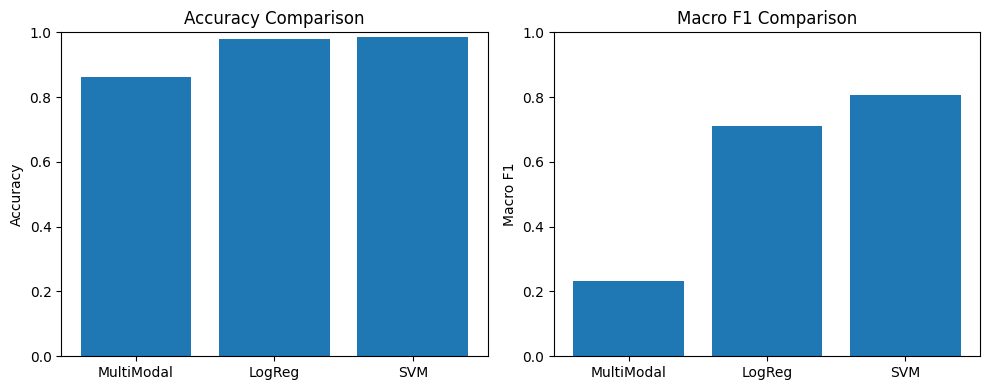

In [101]:
import matplotlib.pyplot as plt

model_names = ['MultiModal', 'LogReg', 'SVM']
accs = [
    accuracy_score(mm_y_true, mm_y_pred),
    accuracy_score(y_val, pred_lr),
    accuracy_score(y_val, pred_svm)
]
f1s = [
    f1_score(mm_y_true, mm_y_pred, average='macro'),
    f1_score(y_val, pred_lr, average='macro'),
    f1_score(y_val, pred_svm, average='macro')
]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(model_names, accs)
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Accuracy Comparison')

plt.subplot(1,2,2)
plt.bar(model_names, f1s)
plt.ylabel('Macro F1')
plt.ylim(0,1)
plt.title('Macro F1 Comparison')
plt.tight_layout()
plt.show()
